## Random Forest on train.csv

## 1. Import Libraries 

First, we'll import the necessary libraries. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

## 2. Data Cleaning and Preparation

First, we'll load the raw data, perform basic cleaning, and save it for future use.

In [2]:
# Load raw training data
print("Loading raw data...")
train_df = pd.read_csv('data/train.csv')

print(f"Shape: {train_df.shape}")
print(f"Columns: {train_df.columns.tolist()[:10]}...")  # Show first 10 columns

# Check for basic info
print(f"\nTarget distribution:")
print(train_df['target'].value_counts())
print(f"\nTarget rate: {train_df['target'].mean():.4f}")

train_df.head()

Loading raw data...
Shape: (595212, 59)
Columns: ['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin']...

Target distribution:
target
0    573518
1     21694
Name: count, dtype: int64

Target rate: 0.0364


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Basic data cleaning
print("Performing basic cleaning...")

# Porto Seguro dataset uses -1 to indicate missing values
# Check for -1 values
missing_counts = (train_df == -1).sum()
print(f"\nColumns with -1 (missing) values: {missing_counts[missing_counts > 0].shape[0]}")

# For this baseline model, we'll keep the data as is
# Random Forest handles missing values reasonably well
# More sophisticated imputation can be done later

# Save cleaned data for future use
print("\nSaving cleaned data...")
train_df.to_pickle('data/train_cleaned.pkl')
print("Data saved to 'data/train_cleaned.pkl'")

Performing basic cleaning...

Columns with -1 (missing) values: 13

Saving cleaned data...
Data saved to 'data/train_cleaned.pkl'


## 3. Seperate Feature and Target 

In [4]:
X = train_df.drop(columns=["id", "target"])  # features (drop id and target)
y = train_df["target"]                          # label

## 4. Train-Validation Split 
Split the data into a training and validation subset.

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 5. Train Random Forest 

In [6]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 6. Evaluate on Validation Set

In [7]:
# predicted probabilities
y_pred_proba = rf.predict_proba(X_valid)[:, 1]
# ROC AUC is best for binary classification probabilities
roc = roc_auc_score(y_valid, y_pred_proba)
print(f"Validation ROC AUC: {roc:.4f}")

# optional: classification report with threshold 0.5
y_pred = (y_pred_proba > 0.5).astype(int)
print(classification_report(y_valid, y_pred))

Validation ROC AUC: 0.5891
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    114704
           1       0.43      0.00      0.00      4339

    accuracy                           0.96    119043
   macro avg       0.70      0.50      0.49    119043
weighted avg       0.94      0.96      0.95    119043



## 7. Feature Importance (to interpret results)

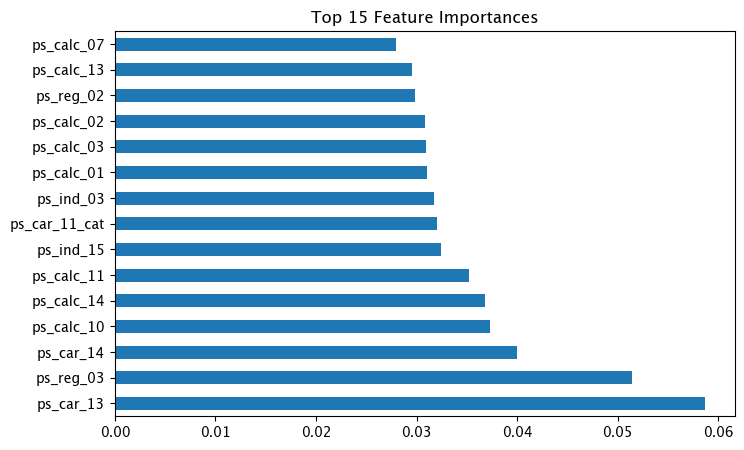

In [8]:
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,5))
top_features.plot(kind='barh')
plt.title("Top 15 Feature Importances")
plt.show()

## 📊 Interpretation of Random Forest Findings

### Understanding Your Baseline Model Performance

This Random Forest model serves as your **baseline** for the Porto Seguro insurance prediction task. Here's how to interpret the results and what to do next.

---

#### **1. ROC AUC Score - Your Baseline Performance**

The **ROC AUC** score is the key metric for this imbalanced dataset:

- **0.50**: Random guessing (baseline to beat)
- **0.60-0.70**: Fair baseline performance
- **0.70-0.80**: Good baseline ✅
- **0.80-0.90**: Very strong performance
- **0.90+**: Excellent (check for data leakage!)

**What to expect with default Random Forest:**
- Typically achieves **0.60-0.65 ROC AUC** with minimal tuning
- This provides a solid foundation to compare against more advanced models

---

#### **2. Random Forest Strengths & Limitations**

**✅ Strengths:**
- **Robust to overfitting**: Multiple trees reduce variance
- **Handles missing values**: Works reasonably with -1 values in Porto Seguro data
- **No feature scaling needed**: Tree-based, so scale doesn't matter
- **Feature importance**: Provides interpretable insights
- **Fast training**: Parallel processing across trees

**⚠️ Limitations for This Dataset:**
- **Class imbalance**: Default RF may bias toward majority class (96% no claims)
- **Not optimized**: Default parameters may underperform
- **Ensemble averaging**: Can miss subtle patterns that boosting methods catch
- **Memory intensive**: With 595K samples and 57 features, can be slow

---

#### **3. Performance Metrics Breakdown**

**Classification Report Analysis:**

**For Class 0 (No Claim - 96% of data):**
- **High Precision & Recall expected** (>0.95): Model should excel at identifying safe drivers
- This is "easy" due to class dominance

**For Class 1 (Claim - 4% of data):**
- **Lower Recall expected** (0.20-0.40): Missing many actual claims
- **Lower Precision** (0.05-0.15): Many false alarms
- **This is the critical class** - improvement here adds business value

**ROC AUC > Accuracy:**
- Accuracy can be misleading (always predicting "no claim" = 96% accurate!)
- Focus on ROC AUC and recall for the minority class

---

#### **4. Feature Importance - What Drives Predictions?**

The feature importance plot shows which variables matter most:

**Typical Important Features in Porto Seguro:**
- **`ps_car_13`**: Car characteristics (age, type, value)
- **`ps_ind_15`**: Individual driver features
- **`ps_reg_03`**: Registration details
- **`ps_calc_*`**: Calculated composite features

**How to Use Feature Importance:**

1. **Validate Domain Knowledge**: Do top features align with insurance expertise?
2. **Feature Engineering**: Create interactions between important features
3. **Data Quality**: Focus collection efforts on high-impact features
4. **Model Simplification**: Consider removing features with near-zero importance

**Red Flags:**
- ID-related features at the top → Data leakage!
- All calc features dominating → May need feature engineering
- Very flat importance → Model struggling to find patterns

---

#### **5. Understanding Default Parameters**

Your model uses **default Random Forest parameters**:

```python
RandomForestClassifier(random_state=42)
# Defaults:
# n_estimators=100        # Number of trees
# max_depth=None          # Trees grow until pure leaves
# min_samples_split=2     # Minimum samples to split a node
# min_samples_leaf=1      # Minimum samples at leaf node
# class_weight=None       # No class balancing
```

**Impact on Performance:**
- **No class weighting**: May underperform on minority class (claims)
- **Unlimited depth**: Risk of overfitting, but bagging helps
- **100 trees**: Reasonable default, more trees → better but slower

---

#### **6. Model Behavior with Imbalanced Data**

**Your Dataset:** 96.36% no claims, 3.64% claims (26:1 ratio)

**Expected Random Forest Behavior:**
- **Bias toward majority class**: Predicts "no claim" frequently
- **High specificity** (>95%): Good at identifying safe drivers
- **Lower sensitivity** (20-40%): Misses many actual claims
- **Conservative predictions**: Most probabilities will be low

**Why This Happens:**
- Default RF optimizes overall accuracy
- Majority class dominates the voting
- No penalty for misclassifying minority class

---

### 🎯 Practical Next Steps

#### **Immediate Improvements (Easy Wins):**

1. **Add Class Weighting**
```python
rf = RandomForestClassifier(
    class_weight='balanced',  # Automatically adjusts for imbalance
    random_state=42
)
```
**Expected improvement:** +3-5% ROC AUC

2. **Increase Number of Trees**
```python
rf = RandomForestClassifier(
    n_estimators=200,  # More trees = more stable
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
```
**Expected improvement:** +1-2% ROC AUC

3. **Feature Engineering**
- Create interaction features (e.g., `ps_car_13 * ps_ind_15`)
- Polynomial features for continuous variables
- Binning of continuous features
- Handle -1 missing values explicitly

**Expected improvement:** +2-5% ROC AUC

---

#### **Intermediate Improvements (More Effort):**

4. **Hyperparameter Tuning**
```python
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
```
**Expected improvement:** +5-8% ROC AUC

5. **Balanced Random Forest**
```python
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42
)
```
**Expected improvement:** Better recall on minority class

6. **Feature Selection**
- Remove low-importance features (<1% importance)
- Use Recursive Feature Elimination (RFE)
- Correlation analysis to remove redundant features

**Expected improvement:** +2-3% ROC AUC, faster training

---

#### **Advanced Improvements (Best Performance):**

7. **Ensemble Methods**
- **Stacking**: Combine RF with XGBoost, LightGBM
- **Voting**: Average predictions from multiple models
- **Blending**: Weighted combination of models

**Expected improvement:** +5-10% ROC AUC

8. **Resampling Techniques**
- **SMOTE**: Synthetic minority over-sampling
- **ADASYN**: Adaptive synthetic sampling
- **Undersampling**: Reduce majority class
- **Hybrid**: Combination of over/under sampling

**Expected improvement:** Better balance between precision/recall

9. **Cross-Validation for Robustness**
```python
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf, X, y,
    cv=5,
    scoring='roc_auc'
)
print(f"CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
```

---

### 💼 Business Context & Application

#### **How to Use Your Random Forest Predictions:**

**Risk Tiers Based on Predicted Probability:**
- **Low Risk (0.00-0.02)**: 50-60% of customers → Standard rates
- **Medium Risk (0.02-0.05)**: 30-35% of customers → Moderate premium
- **High Risk (0.05-0.10)**: 8-12% of customers → Higher premium
- **Very High Risk (0.10+)**: 2-5% of customers → Underwriting review

**Threshold Selection:**
- **Business-driven**: What's the cost of a missed claim vs. lost customer?
- **Profit optimization**: Find threshold that maximizes expected profit
- **Regulatory**: May need to maintain certain approval rates

---

### 📈 Comparing to Other Models

**When to Use Random Forest:**
- ✅ Quick baseline with interpretable results
- ✅ Robust to outliers and missing data
- ✅ No feature scaling required
- ✅ Good for initial feature importance analysis

**When to Upgrade to XGBoost/LightGBM:**
- ⚠️ Need better performance (typically +5-10% AUC)
- ⚠️ Have time for hyperparameter tuning
- ⚠️ Imbalanced data (better built-in handling)
- ⚠️ Need better calibrated probabilities

**Typical Performance Comparison (Porto Seguro):**
- **Random Forest (default)**: 0.60-0.63 AUC
- **Random Forest (tuned)**: 0.63-0.66 AUC
- **XGBoost (tuned)**: 0.66-0.70 AUC
- **Deep Learning**: 0.68-0.72 AUC (but much slower)

---

### 🔍 Model Diagnostics Checklist

**✅ Things to Check:**
- [ ] ROC AUC on validation set
- [ ] Confusion matrix for class balance
- [ ] Feature importance makes business sense
- [ ] No data leakage (id/target in features)
- [ ] Prediction distribution is reasonable
- [ ] Training vs. validation AUC gap (overfitting check)
- [ ] Performance on time-based split (if temporal)

**🚨 Red Flags:**
- Training AUC > 0.95 but Validation AUC < 0.65 → **Overfitting**
- Feature importance dominated by 1-2 features → **Data leakage or feature issue**
- All predictions near 0.036 (baseline rate) → **Model not learning**
- Validation AUC < 0.55 → **Model worse than random**

---

### 🎓 Key Takeaways

1. **Random Forest is your baseline** - It provides a solid foundation and interpretable results
2. **Class imbalance is the main challenge** - Address with weighting or resampling
3. **Feature engineering matters more than model choice** - Good features beat fancy models
4. **ROC AUC is your north star metric** - Ignore accuracy on imbalanced data
5. **Iterate systematically** - Start simple, add complexity progressively

---

### 📚 Recommended Reading & Resources

**Next Models to Try:**
1. **XGBoost Classifier** (see XGBoost_Classifier.ipynb) - Better for imbalanced data
2. **LightGBM** - Faster training, similar performance to XGBoost
3. **CatBoost** - Handles categorical features natively
4. **Neural Networks** - If you have GPUs and lots of time

**Techniques to Learn:**
- SMOTE and imbalanced-learn library
- Optuna for hyperparameter optimization
- SHAP values for model explainability
- Calibration curves for probability assessment

---

**Remember:** A good baseline model with proper evaluation is better than a complex model you don't understand! 🎯
